# Algorithmes Évolutionnaires — Travaux dirigés N°5 : régression symbolique

## Résumé
Dans cette séance, nous appliquerons la programmation génétique à un problème de régression symbolique. Pour ce faire, nous utiliserons le framework DEAP.
### Introduction
Dans la régression, on cherche à ajuster les paramètres d’un modèle (linéaire, logistique, ou autre) pour approcher une variable à partir d’autres qui lui sont corrélées. Pourtant, la forme générale du modèle est donnée ou, dit autrement, le modèle est une hypothèse. La régression symbolique, par contre, consiste à chercher un modèle (c-à-d une fonction) qui approche la variable cible à partir des autres, sans faire d’hypothèses sur sa forme. La programmation génétique semble donc un outil parfaitement adapté pour ce genre d’exercice.
Nous allons utiliser le framework DEAP pour développer une approche de la régression symbolique basée sur la programmation génétique. Nous supposerons que le jeu de données du problème à résoudre soit donné dans un fichier en format TSV (de l’anlais tab-separated values), dont la première ligne contient les noms des variables et les lignes suivantes contiennent les observations dont ont dispose. La variable à approcher à partir des autres est, par convention, la dernière.

### Consignes
1. Vous pouvez vous inspirer du tutoriel avancé de DEAP sur la programmation génétique.
2. Choisissez un ensemble d’opérations primitives suffisant pour exprimer même les fonctions les plus complexes ; outre aux opérations arithmétiques, pensez à inclure aussi l’exponentiel, le logarithme et des fonctions trigonométriques.
3. Faites attention aux opérations/fonctions dont le domaine de définition ne coincide pas avec R : pour éviter tout problème, redéfinissez-les pour les « protéger » des arguments hors domaine.

In [1]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

* On cré un ensemble de primitives qui seront chaque nœud de la structure arborescente. Ici, les opérations arithmétiques de base, les fonctions triangulaires et les nombres aléatoires temporaires sont inclus dans l'ensemble.

In [2]:
# Define new functions
def safeDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 0

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(safeDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

Afin d'éviter l'erreur due à la division zéro, la division est nouvellement définie et ajoutée à la primitive, et les autres utilisent les fonctions du module opérateur et du module mathématique de python. Le deuxième argument de addPrimitive indique le nombre d'arguments pour la fonction primitive. addEphemeralConstant est utilisé lorsque la fin d'un nœud utilise une valeur générée à partir d'une fonction telle qu'un nombre aléatoire au lieu d'une constante. Ici vous pouvez voir que nous définissons un nombre aléatoire qui générera l'un de -1,0,1. Je ne pense pas que ce sera beaucoup choisi dans ce numéro, mais ... Le deuxième argument du PrimitiveSet indique le nombre d'entrées de programme. Cette fois, il n'y en a qu'un, il est nommé "ARG0" par défaut, mais je l'ai renommé en "x" dans renameArguments.

Ensuite, comme dans l'exemple GA précédent, utilisez ** creator ** pour définir le problème de minimisation et le type individuel.

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

Ensuite, en utilisant **toolbox**, nous créerons des méthodes de génération d'individus et de population, des fonctions d'évaluation, des intersections, des mutations, des méthodes de sélection, etc. gp.genHalfAndHalf est une fonction qui crée des arbres, mais min_ et max_ spécifient les profondeurs minimale et maximale de l'arbre, et genGrow (génération d'arbres où la profondeur de chaque nœud feuille peut être différente) Il est conçu pour faire genFull (génération d'arbres avec la même profondeur de chaque nœud de feuille) en deux. gp.compile crée une fonction qui peut réellement être exécutée à partir d'un individu. À la fin, la mutation est spécifiée en ajoutant un nouveau sous-arbre au nœud.

In [4]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSymbReg(individual, points):
    #Conversion de la représentation arborescente en fonction
    func = toolbox.compile(expr=individual)
    #Calcul de l'erreur quadratique moyenne entre la formule estimée et la formule vraie
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

Ensuite, créez la fonction principale et exécutez-la. Tout d'abord, définissez les informations statistiques que vous souhaitez calculer afin d'obtenir les informations statistiques, puis générez la population initiale et effectuez le calcul d'évolution avec eaSimple. Lorsqu'elles sont exécutées, les informations statistiques pour chaque génération seront sorties comme indiqué ci-dessous.

In [5]:
def main():
    random.seed(318)

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=hof, verbose=True)
    #Afficher le journal
    return pop, log, hof
if __name__ == "__main__":
    main()

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min     	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	1.77307	0  	30.24	0.450825	300   	2.67131	3.54667	0  	7  	2  	300   	1.49482
1  	164   	1.35902	1  	44.3937	0.183711	164   	2.86698	3.71   	1  	12 	1  	164   	1.92161
2  	161   	2.09848	2  	315.686	0.165572	161   	18.1875	3.69   	2  	16 	1  	161   	1.81123
3  	171   	15.5821	3  	4344.03	0.165572	171   	250.337	3.74   	3  	15 	1  	171   	1.8145 
4  	151   	0.853335	4  	14.538 	0.165572	151   	1.16069	3.92667	4  	17 	1  	151   	2.07235
5  	157   	0.818335	5  	19.1352	0.165572	157   	1.18963	4.08   	5  	17 	1  	157   	2.08173
6  	172   	0.822971	6  	18.9239	0.165572	172   	1.20164	4.42333	6  	17 	1  	172   	2.40641
7  	158   	0.754532	7  	17.8009	0.165572	158   	1.4

In [10]:
# Dans ANACONDA PROMPT : conda install graphviz pygraphviz -c alubbock

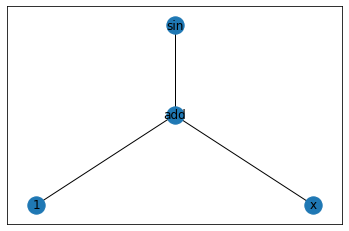

In [17]:
expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)
import matplotlib.pyplot as plt
import networkx as nx

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.nx_agraph.graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()